In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

# ── USER PARAMS
TICKER = "NVDA"
START = "2024-01-01"
END = "2025-07-13"
INTERVAL = "1d"
VISIBLE_BARS = 180  # decrease for fewer datapoints or increase for broader history
TICK_SIZE = 0.01  # smaller values give finer resolution, larger smooth the chart

# color definitions
BULL_EDGE_COLOR = "#089981"
BULL_FILL_COLOR = (8 / 255, 153 / 255, 129 / 255, 0.90)
BEAR_EDGE_COLOR = "#F23645"
BEAR_FILL_COLOR = (242 / 255, 54 / 255, 69 / 255, 0.90)

# - FETCH DATA
df = yf.download(TICKER,
                 start=START,
                 end=END,
                 interval=INTERVAL,
                 auto_adjust=True,
                 progress=True)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
vis = df.tail(VISIBLE_BARS).copy()

[*********************100%***********************]  1 of 1 completed


In [12]:
vis['bucket'] = (vis['Close']/TICK_SIZE).round().astype(int) * TICK_SIZE
bull = vis[vis['Close'] > vis['Open']]
bear = vis[vis['Close'] < vis['Open']]

bull_map = bull.groupby('bucket')['Volume'].sum()
bear_map = bear.groupby('bucket')['Volume'].sum()

In [13]:
# ── BUILD PRICE→VOLUME MAPS
vis['bucket'] = (vis['Close']/TICK_SIZE).round().astype(int) * TICK_SIZE

# split into directional candles
bull = vis[vis['Close'] > vis['Open']]
bear = vis[vis['Close'] < vis['Open']]

# group volume by price bucket
bull_map = bull.groupby('bucket')['Volume'].sum()
bear_map = bear.groupby('bucket')['Volume'].sum()

# scale factors for relative bar widths
bull_max = bull_map.max() if not bull_map.empty else 0
bear_max = bear_map.max() if not bear_map.empty else 0

# totals and peaks
bull_total = bull_map.sum()
bear_total = bear_map.sum()
bull_peak_price = bull_map.idxmax() if not bull_map.empty else np.nan
bear_peak_price = bear_map.idxmax() if not bear_map.empty else np.nan

# sort buckets top down
bull_levels = bull_map.sort_index(ascending=False)
bear_levels = bear_map.sort_index(ascending=False)

# cumulative volume fraction
bull_frac = bull_levels.cumsum() / bull_total if bull_total > 0 else pd.Series([], dtype=float)
bear_frac = bear_levels.cumsum() / bear_total if bear_total > 0 else pd.Series([], dtype=float)

# volume-weighted average price and median
bull_vwap = (bull_map.index.to_numpy() * bull_map.values).sum() / bull_total if bull_total > 0 else np.nan
bear_vwap = (bear_map.index.to_numpy() * bear_map.values).sum() / bear_total if bear_total > 0 else np.nan

bull_median = bull_frac[bull_frac >= 0.5].index[0] if not bull_frac.empty else np.nan
bear_median = bear_frac[bear_frac >= 0.5].index[0] if not bear_frac.empty else np.nan

# y-axis range
price_min = min(
    bull_levels.index.min() if not bull_levels.empty else np.inf,
    bear_levels.index.min() if not bear_levels.empty else np.inf,
    vis['Low'].min()
)
price_max = max(
    bull_levels.index.max() if not bull_levels.empty else -np.inf,
    bear_levels.index.max() if not bear_levels.empty else -np.inf,
    vis['High'].max()
)

/var/folders/36/l3z8k4xd4wl3mwvflx34w8vm0000gn/T/ipykernel_78803/286247365.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


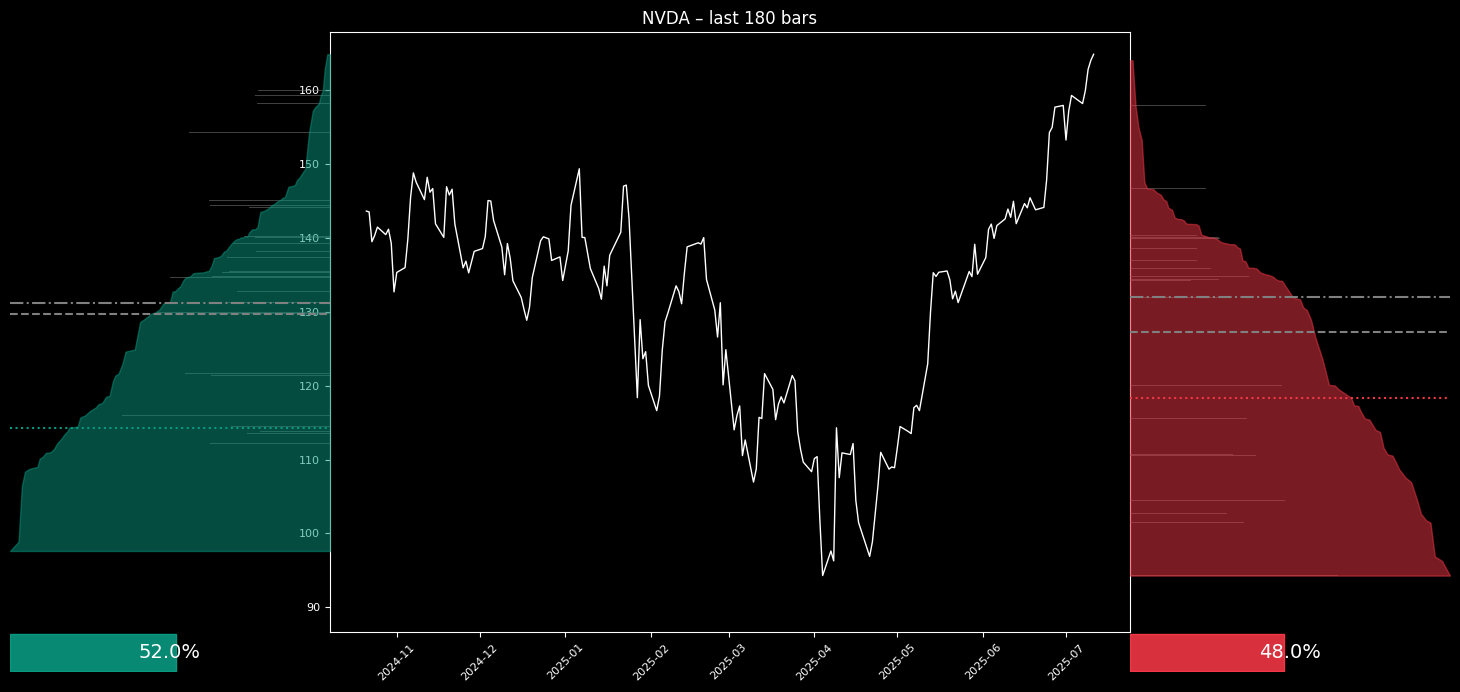

In [14]:
# ── PLOT
plt.style.use('dark_background')
fig = plt.figure(figsize=(16,8))  # adjust to scale figure size

# layout positioning
left_margin = 0.05
bull_width  = 0.20
price_width = 0.50
price_left  = left_margin + bull_width
bear_left   = price_left + price_width
bottom      = 0.15
height      = 0.75
box_height  = 0.05
box_bottom  = bottom - box_height

# price panel
price_ax = fig.add_axes([price_left, bottom, price_width, height])
price_ax.plot(vis.index, vis['Close'], color='white', lw=1)
price_ax.set_ylim(price_min, price_max)

date_loc = AutoDateLocator(minticks=5, maxticks=10)
price_ax.xaxis.set_major_locator(date_loc)
price_ax.xaxis.set_major_formatter(AutoDateFormatter(date_loc))
price_ax.tick_params(axis='x', rotation=45, colors='white', labelsize=8)
price_ax.tick_params(axis='y', colors='white', labelsize=8)
price_ax.set_title(f"{TICKER} – last {VISIBLE_BARS} bars", color='white')

# bullish depth panel (left)
bull_ax = fig.add_axes([left_margin, bottom, bull_width, height], sharey=price_ax)
if not bull_frac.empty:
    if bull_max > 0:
        bull_norm = bull_levels.values / bull_max
        bull_ax.barh(
            bull_levels.index,
            bull_norm,
            height=TICK_SIZE*3,
            left=1 - bull_norm,
            color='gray',
            alpha=0.5
        )
    bull_ax.fill_betweenx(
        bull_frac.index,
        1 - bull_frac,
        1,
        facecolor=BULL_FILL_COLOR,
        edgecolor=BULL_EDGE_COLOR,
        linewidth=1, alpha=0.5
    )
    bull_ax.axhline(bull_peak_price, xmin=0, xmax=1, color=BULL_EDGE_COLOR, linestyle='dotted')
    bull_ax.axhline(bull_median, xmin=0, xmax=1, color='gray', linestyle='dashdot')
    bull_ax.axhline(bull_vwap, xmin=0, xmax=1, color='gray', linestyle='dashed')
bull_ax.set_xlim(0,1)
bull_ax.axis('off')

# bearish depth panel (right)
bear_ax = fig.add_axes([bear_left, bottom, bull_width, height], sharey=price_ax)
if not bear_frac.empty:
    if bear_max > 0:
        bear_norm = bear_levels.values / bear_max
        bear_ax.barh(
            bear_levels.index,
            bear_norm,
            height=TICK_SIZE*3,
            left=0,
            color='gray',
            alpha=0.5
        )
    bear_ax.fill_betweenx(
        bear_frac.index,
        0,
        bear_frac,
        facecolor=BEAR_FILL_COLOR,
        edgecolor=BEAR_EDGE_COLOR,
        linewidth=1, alpha=0.5
    )
    bear_ax.axhline(bear_peak_price, xmin=0, xmax=1, color=BEAR_EDGE_COLOR, linestyle='dotted')
    bear_ax.axhline(bear_median, xmin=0, xmax=1, color='gray', linestyle='dashdot')
    bear_ax.axhline(bear_vwap, xmin=0, xmax=1, color='gray', linestyle='dashed')
bear_ax.set_xlim(0,1)
bear_ax.axis('off')

# volume share summary
bull_share = bull_total / (bull_total + bear_total)
bear_share = bear_total / (bull_total + bear_total)

bull_box = fig.add_axes([left_margin, box_bottom, bull_width, box_height])
bull_box.barh(0, bull_share, height=1, color=BULL_FILL_COLOR, edgecolor=BULL_EDGE_COLOR)
bull_box.set_xlim(0,1)
bull_box.axis('off')
bull_box.text(0.5, 0, f"{bull_share:.1%}", ha='center', va='center', color='white', fontsize=14)

bear_box = fig.add_axes([bear_left, box_bottom, bull_width, box_height])
bear_box.barh(0, bear_share, height=1, color=BEAR_FILL_COLOR, edgecolor=BEAR_EDGE_COLOR)
bear_box.set_xlim(0,1)
bear_box.axis('off')
bear_box.text(0.5, 0, f"{bear_share:.1%}", ha='center', va='center', color='white', fontsize=14)

plt.tight_layout()
plt.show()